In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
from skimage import io
from skimage import data
import numpy as np
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # width and height
mpl.rc('image', cmap='gray')

In [2]:
def rgb2gray(img):
    if len(img.shape) < 3:
        return img
    return 0.2125*img[:,:,0] + 0.7154*img[:,:,1] + 0.0721*img[:,:,2]

In [3]:
def toBlocksOld(img, size_h=8, size_w=8):
    h, w = img.shape
    h, w = math.floor(h/size_h), math.floor(w/size_w)
    blocks = np.empty((h, w, size_h, size_w))
    for J in range(h):
        for I in range(w):
            new_block = np.zeros((size_h, size_w))
            y_start, x_start = J*size_h, I*size_w
            for j in range(size_h):
                for i in range(size_w):
                    new_block[j][i] = img[y_start+j][x_start+i]
            blocks[J][I] = new_block
    return blocks

In [4]:
def toBlocks(A, n_rows=8, n_cols=8):
    if A.shape[0] % n_rows != 0 or A.shape[1] % n_cols != 0:
        rows_end = A.shape[0] - A.shape[0] % n_rows
        cols_end = A.shape[1] - A.shape[1] % n_cols
        A = A[0:rows_end, 0:cols_end]
    B = A.reshape((-1, n_rows, A.shape[1]//n_cols, n_cols))
    return B.transpose((0,2,1,3))

In [5]:
def fromBlocksOld(img):
    (img_h, img_w, block_h, block_w) = img.shape
    output = np.zeros((img_h*block_h, img_w*block_w))
    for J in range(img_h):
        for I in range(img_w):
            block = img[J, I]
            for j in range(block_h):
                for i in range(block_w):
                    y = J * block_h + j
                    x = I * block_w + i
                    output[y, x] = block[j, i]
    return output

In [6]:
def fromBlocks(img):
    rows = []
    for J in range(img.shape[0]):
        rows.append( np.concatenate(img[J], axis=1) )
    
    return np.array(np.concatenate(rows))

In [7]:
def averagePixDiff(im1, im2):
    if im1.shape != im2.shape:
        print("(in avePixDiff) Error: the shapes of two arrays doesn' match")
        return -1
    #return np.abs(im1-im2).mean()
    #return np.square(im1-im2).mean()
    return abs(im1.mean()-im2.mean())

In [8]:
def getCharBlocks(sentence, fontName, fontSize, block_h, block_w, inverted=False):
    myFont = ImageFont.truetype(fontName, fontSize)
    fillValue = 0
    characters = Image.open('ascii_char_holder.png')
    if inverted:
        fillValue = 255
        characters = Image.open('ascii_char_holder_black.png')
    drawer = ImageDraw.Draw(characters)
    for i, char in enumerate(sentence):
        drawer.text((i*block_w, 0), char, font=myFont, fill=0)
    #characters.show()
    characterArray = np.asarray(characters)
    characterArray = rgb2gray(characterArray)
    charBlocks = toBlocks(characterArray, block_h, block_w)
    return charBlocks[0]

In [9]:
def getAsciiImage(image, charsToUse, textInfo, inverted=False):
    print("in getAsciiImage() ...\nimage size: {}x{}".format(image.shape[1],image.shape[0]))

    # Generate char blocks
    sentence = ""
    charBlocks = getCharBlocks(charsToUse, textInfo["fontName"], textInfo["fontSize"], textInfo["block_h"], textInfo["block_w"], inverted)
    bH, bW = textInfo["block_h"], textInfo["block_w"]

    # Partition image blocks
    print("converting to blocks ...")
    imageBlocks = toBlocks(image, bH, bW)
    ascii_blocks = np.empty(imageBlocks.shape)
    (imH, imW, rubb, ish) = imageBlocks.shape

    # IMAGE BLOCKS SCALING
    # Get upper and lower means for image blocks
    threshLowerImage = math.inf
    threshUpperImage = 0
    for row in imageBlocks:
        for block in row:
            m = block.mean()
            if m < threshLowerImage: threshLowerImage = m
            if m > threshUpperImage: threshUpperImage = m
    #rint(threshLowerImage, threshUpperImage)

    # Get darkest char block mean
    threshLowerChar = math.inf
    threshUpperChar = 255
    for block in charBlocks:
        m = block.mean()
        if m < threshLowerChar: threshLowerChar = m
    
    #print("darkest char block mean: ", threshLowerChar)

    # Scale image blocks
    DR_char = threshUpperChar - threshLowerChar
    DR_image = threshUpperImage - threshLowerImage

    imageBlocksScaled = ( imageBlocks - threshLowerImage ) * ( DR_char / DR_image ) + threshLowerChar

    min = math.inf
    max = 0
    for row in imageBlocksScaled:
        for block in row:
            m = block.mean()
            if m < min: min = m
            if m > max: max = m
    #print("darkest scaled image block mean: ", min)
    #print("lightest scaled image block mean: ", max)

    # Process blocks
    print("blocks to process: {}x{} = {}".format(imH, imW, imH*imW))
    for iy, ix in np.ndindex(imH, imW):
        blocks_processed = iy * imW + ix
        if blocks_processed % 500 == 0: print("blocks processed = {}/{} ...".format(blocks_processed, imH*imW), end="\r")
        image_block = imageBlocksScaled[iy, ix]
        min = math.inf
        best_index = 0
        for i in range(len(charBlocks)):
            aveDiff = averagePixDiff(image_block, charBlocks[i])
            if aveDiff < min:
                min = aveDiff
                best_index = i
        
        ascii_blocks[iy, ix] = charBlocks[ best_index ]
        sentence += charsToUse[ best_index ]
        if ix == imW-1: sentence += "\n"
    print("blocks processed = {}/{} ...".format(blocks_processed, imH*imW))
    print("departitioning blocks and returning ...")
    return fromBlocks(ascii_blocks), sentence

In [10]:
def getImage(image_name):
    folder = "images"
    return rgb2gray(io.imread( "{}\{}".format(folder, image_name) ))

In [11]:
def getCharacterString():
    CHARACTERS = ""
    for x in range(32,127): CHARACTERS += chr(x)
    return CHARACTERS

in getAsciiImage() ...
image size: 1824x2160
converting to blocks ...
blocks to process: 180x260 = 46800
blocks processed = 46799/46800 ...
departitioning blocks and returning ...


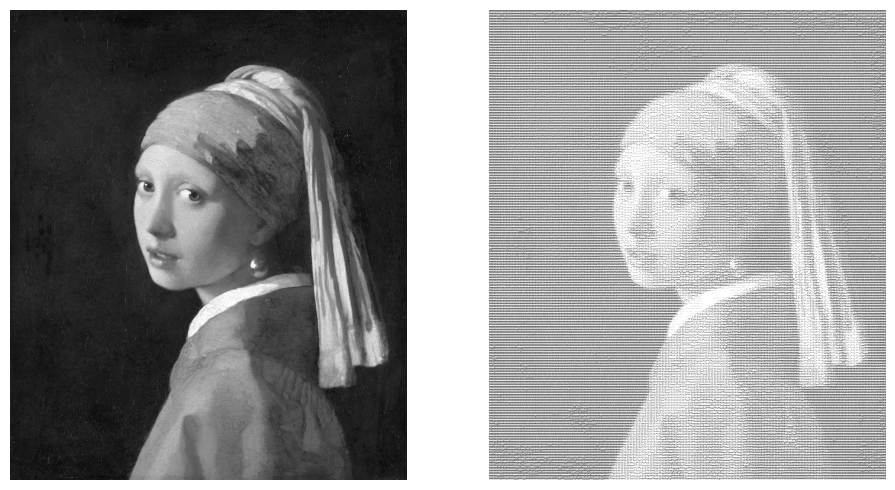

In [15]:
# RUNNER
# 
# Image files:
# Astronaut.png, Lenna.png, cliff_tree.jpg, wedding.jpg, senators.jpg, the_great_wave.jpg, rings_of_saturn.jpg, saturn.jpg, saturn_and_its_3_moons.jpg, 
# cheguevara.jpg, girl_with_pearl_earring.jpg

x = 1
textInfo = {
    "fontName" : "courier.ttf",
    "fontSize" : 12 * x,
    "block_h" : 12 * x,
    "block_w" : 7 * x
}
charsToUse = getCharacterString()

# GET IMAGE
imageName = "girl_with_pearl_earring.jpg"
image = getImage(imageName)
ascii_image, ascii_text = getAsciiImage(image, charsToUse, textInfo, inverted=False)

# DISPLAY
images = (image, ascii_image)
fig, ax = plt.subplots(1, len(images))
for i, im in enumerate(images):
    ax[i].imshow(im, vmin=0, vmax=255), ax[i].axis('off')
fig.tight_layout()

#print("Image as text: \n\n{}".format(ascii_text))
ascii_image_image = Image.fromarray(ascii_image)

In [13]:
# RUN THIS TO: DISPLAY IMAGE
ascii_image_image.show()

In [ ]:
# RUN THIS TO: SAVE IMAGE
ascii_image_image.convert('RGB').save("ascii_images/ascii_{} ({}pt_{}x{}).png".format(imageName.split('.')[0], textInfo["fontSize"], textInfo["block_h"], textInfo["block_w"]))